In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm,Normalize
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [131]:
!pwd

/Volumes/HDD750GB/Programs/Fisher/github/Wfirst/Core


In [132]:
df = pd.read_csv('../tt0_2.zphot',sep=' ',index_col=False)#,header=None)
df_w=pd.read_csv('../tt0_14.zphot',sep=' ',index_col=False)

df.columns   = ['id', 'ztrue', 'zphot', 'zphoterr', 'N_cm']
df_w.columns = ['id', 'ztrue', 'zphot', 'zphoterr', 'N_cm']

df = df.iloc[:, :-1]
df_w = df_w.iloc[:, :-1]

df   = df.sort_values(by=['ztrue'])   
df_w = df_w.sort_values(by=['ztrue'])   

df = df[df.ztrue<=1.2]
df_w = df_w[df_w.ztrue<=1.2]

In [182]:
xxx = pd.DataFrame(np.linspace(1,10,10))

In [184]:
xxx[0]

0     1.0
1     2.0
2     3.0
3     4.0
4     5.0
5     6.0
6     7.0
7     8.0
8     9.0
9    10.0
Name: 0, dtype: float64

In [187]:
xxx.loc[~xxx[0]>5]

TypeError: ufunc 'invert' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [133]:
'''
thresh_COR = 1.5

### Identify the subset of catastrophic outlier-rejected test galaxies in the requested bin
tx = np.where( ( np.abs( np.array(df_w.zphot) - np.array(df_w.ztrue) ) < thresh_COR ) )[0]
CORzspec = np.array(df_w.ztrue)[tx]
CORzphot = np.array(df_w.zphot)[tx]

plt.hist2d( CORzphot, CORzspec, bins=100, range=[[0.0,1.2],[0.0,1.2]], norm=LogNorm(clip=True), \
            cmin=1, cmap='Greens');
plt.xlabel('z_phot',fontsize=15);plt.ylabel('z_true',fontsize=15)
plt.text(0.1,1.0,'CORE Bias Points',fontsize=15)
'''

"\nthresh_COR = 1.5\n\n### Identify the subset of catastrophic outlier-rejected test galaxies in the requested bin\ntx = np.where( ( np.abs( np.array(df_w.zphot) - np.array(df_w.ztrue) ) < thresh_COR ) )[0]\nCORzspec = np.array(df_w.ztrue)[tx]\nCORzphot = np.array(df_w.zphot)[tx]\n\nplt.hist2d( CORzphot, CORzspec, bins=100, range=[[0.0,1.2],[0.0,1.2]], norm=LogNorm(clip=True),             cmin=1, cmap='Greens');\nplt.xlabel('z_phot',fontsize=15);plt.ylabel('z_true',fontsize=15)\nplt.text(0.1,1.0,'CORE Bias Points',fontsize=15)\n"

In [134]:
len(CORzphot)

128190

In [135]:
# Based on : https://github.com/dirac-institute/CMNN_Photoz_Estimator/blob/master/cmnn_analysis.py
def CORiqrbias(zphot,ztrue):
    ###   thresh_COR : zspec-zphot threshold to define "catastrophic outlier rejection"
    thresh_COR = 1.5

    ### Identify the subset of catastrophic outlier-rejected test galaxies in the requested bin
    tx = np.where( ( np.abs( zphot - ztrue ) < thresh_COR ) )[0]
    CORzspec = ztrue[tx]
    CORzphot = zphot[tx]

    ### Define bin_dzo1pzp for use in all stats
    CORdzo1pzp = ( CORzspec - CORzphot ) / ( float(1.0) + CORzphot )
    CORdzo1pzp=np.array(CORdzo1pzp)
    ### COR Intraquartile Range
    q75, q25   = np.percentile( CORdzo1pzp, [75 ,25] )
    CORIQR     = ( q75 - q25 )
    CORIQRstdd = ( q75 - q25 ) / float(1.349)
    tx         = np.where( ( CORdzo1pzp > q25 ) & ( CORdzo1pzp < q75 ) )[0]

    CORIQRbias = np.mean( CORdzo1pzp[tx] )
    return CORIQRbias

In [136]:
   '''
    bins  = np.linspace(0,1.2,13)
    start = (bins[0] + bins[1])/2.; end = (bins[-1] + bins[-2])/2.

    label = np.linspace(start,end,12)
    print(label)
    
    bins  = np.linspace(0,1.2,25)
    start = (bins[0] + bins[1])/2.; end = (bins[-1] + bins[-2])/2.

    label = np.linspace(start,end,24)
    print(label)
    '''

'\n bins  = np.linspace(0,1.2,13)\n start = (bins[0] + bins[1])/2.; end = (bins[-1] + bins[-2])/2.\n\n label = np.linspace(start,end,12)\n print(label)\n \n bins  = np.linspace(0,1.2,25)\n start = (bins[0] + bins[1])/2.; end = (bins[-1] + bins[-2])/2.\n\n label = np.linspace(start,end,24)\n print(label)\n '

In [171]:
def bias(df):
    n_bin = 24;#12
    bins  = np.linspace(0,1.2,n_bin+1)
    start = (bins[0] + bins[1])/2.; end = (bins[-1] + bins[-2])/2.

    label = np.linspace(start,end,n_bin)
    size=len(df)
    df['bin_z'] = pd.cut(df.ztrue, bins=bins, labels=label)
    df = df[df['bin_z'].notna()]
    N=[];cor=[];zp=[];zs=[];fcore=[];
    for each in label:
        x = df[df['bin_z'] == each]
        N.append(len(x))
        cor.append(CORiqrbias(np.array(x.zphot),np.array(x.ztrue))) # Call the COR_IQR Function
        zp.append(np.mean(x.zphot))
        zs.append(np.mean(x.ztrue))
        fcore.append(len(x)/size)
    N = pd.DataFrame(np.array(N))
    #N.columns = ['N']
    N.reset_index(drop=True, inplace=True)
    cor = pd.DataFrame(cor)
    zs = pd.DataFrame(zs)
    zp = pd.DataFrame(zp)
    l = pd.DataFrame(label)   
    fcore = pd.DataFrame(fcore)
    N =  pd.concat([l,N,zs,zp,cor,fcore],axis=1,ignore_index=True)
    N.columns = ['z','N','z_true','zphot','bias','fcore']
    #N = N.iloc[0:12 , : ] # 12 Bins
    return N

In [172]:
b_w= bias(df_w)
b = bias(df)

In [173]:
print('Fraction in each bin for core points')
b_w.fcore

Fraction in each bin for core points


0     0.000577
1     0.009591
2     0.007485
3     0.011813
4     0.029263
5     0.046480
6     0.039353
7     0.032078
8     0.051220
9     0.068179
10    0.058612
11    0.066331
12    0.081606
13    0.053045
14    0.050199
15    0.063493
16    0.059524
17    0.039836
18    0.050503
19    0.055189
20    0.037606
21    0.032624
22    0.029817
23    0.025575
Name: fcore, dtype: float64

In [143]:
print('Sum of total Fraction ')
b_w.fcore.sum()

Sum of total Fraction 


1.0

Text(0, 0.5, 'CORE Bias')

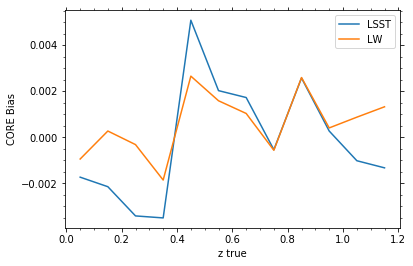

In [144]:
fig, ax = plt.subplots()
plt.plot(b.z,b.bias,label='LSST')
plt.plot(b_w.z,b_w.bias,label='LW')
#plt.plot(b.z,b.fcore,label='LSST-f')
#plt.plot(b_w.z,b_w.fcore,label='LW-f')
plt.legend()
ax.minorticks_on()
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.xlabel('z true')
plt.ylabel('CORE Bias')

Text(0, 0.5, 'F Core')

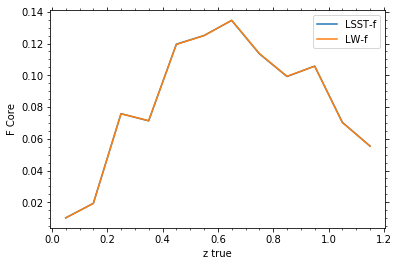

In [145]:
fig, ax = plt.subplots()
#plt.plot(b.z,b.bias,label='LSST')
#plt.plot(b_w.z,b_w.bias,label='LW')
plt.plot(b.z,b.fcore,label='LSST-f')
plt.plot(b_w.z,b_w.fcore,label='LW-f')
plt.legend()
ax.minorticks_on()
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.xlabel('z true')
plt.ylabel('F Core')

Text(0, 0.5, 'F Core*Bias')

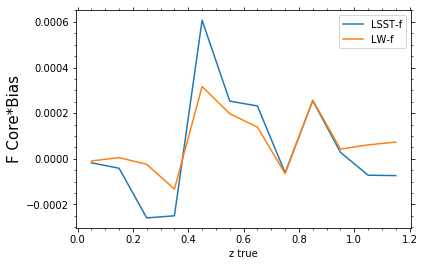

In [146]:
fig, ax = plt.subplots()
#plt.plot(b.z,b.bias,label='LSST')
#plt.plot(b_w.z,b_w.bias,label='LW')
plt.plot(b.z,b.bias*b.fcore,label='LSST-f')
plt.plot(b_w.z,b_w.bias*b_w.fcore,label='LW-f')
plt.legend()
ax.minorticks_on()
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.xlabel('z true')
plt.ylabel('F Core*Bias',fontsize=15)

In [ ]:
#b.to_csv('interpolated_LSST.csv',sep = ' ',index = False)
#b_w.to_csv('interpolated_LW.csv',sep = ' ',index = False)

In [147]:
print('1 LSST_NEW                            2 LW')
display_side_by_side(b,b_w)

1 LSST_NEW                            2 LW


,z,N,z_true,zphot,bias,fcore
0,0.05,1304,0.079959,0.249671,-0.001737,0.010177
1,0.15,2478,0.159753,0.405953,-0.002150,0.019339
2,0.25,9714,0.251158,0.395165,-0.003419,0.075809
3,0.35,9135,0.346542,0.456567,-0.003506,0.071291
4,0.45,15323,0.452942,0.491368,0.005078,0.119583
5,0.55,16020,0.554612,0.570695,0.002021,0.125022
6,0.65,17236,0.645302,0.662661,0.001721,0.134512
7,0.75,14547,0.754403,0.762372,-0.000543,0.113527
8,0.85,12712,0.844574,0.850553,0.002570,0.099206
9,0.95,13552,0.954429,0.971172,0.000268,0.105762


In [148]:
lsst_old = pd.read_csv('../../interpolated_new_2.csv',sep =' ' )# cormean, CORbias. new2 = Cormean,CorIQRbias

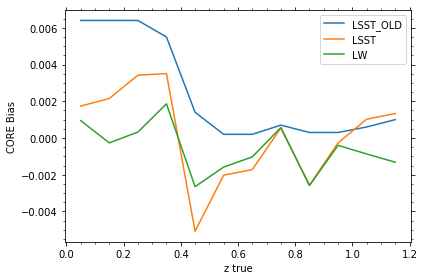

In [149]:
fig, ax = plt.subplots()
plt.plot(lsst_old.z,lsst_old.bias,label='LSST_OLD')
plt.plot(b.z,(-b.bias),label='LSST')
plt.plot(b_w.z,(-b_w.bias),label='LW')
plt.legend()
ax.minorticks_on()
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.xlabel('z true')
plt.ylabel('CORE Bias')
plt.tight_layout()
#plt.savefig('../Plot/Core_Bias.pdf',bbox_inches='tight')

In [150]:
# To compare with Interpolation from Melissa's data
LW_interp = pd.read_csv('interpolated_bias_LW_Melissa.csv',sep=' ')

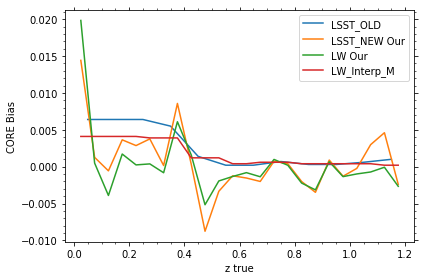

In [190]:
fig, ax = plt.subplots()
plt.plot(lsst_old.z,lsst_old.bias,label='LSST_OLD')
plt.plot(b.z,-(b.bias),label='LSST_NEW Our')
plt.plot(b_w.z,-(b_w.bias),label='LW Our')
plt.plot(LW_interp.z,(LW_interp.bias),label='LW_Interp_M') # M = Melissa's data
plt.legend()
ax.minorticks_on()
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
plt.xlabel('z true')
plt.ylabel('CORE Bias')

#plt.text(0.4,-0.0017,'LW_Interp_M = Interpolated CORIQR from',fontsize=10);plt.text(0.4,-0.0024,'Melissas Data ',fontsize=10);plt.text(0.5,0.005,'12 Bins',fontsize=15)

#plt.text(0.42,-0.007,'LW_Interp_M = Interpolated CORIQR from',fontsize=10);plt.text(0.42,-0.009,'Melissas Data ',fontsize=10);plt.text(0.6,0.005,'24 Bins',fontsize=15)

plt.tight_layout()
#plt.savefig('../Plot/Core_Bias_Compare_w_Melissa_24b_sign_change.pdf',bbox_inches='tight')

In [63]:
LW_outlier = pd.read_csv('../Data/Catastrophic_tzpz_WFIRST_24_intersection.csv',sep=' ' )#Catastrophic_tzpz_WFIRST_24.csv

In [84]:
f_t = LW_outlier.F+b_w.fcore # Adding the fraction bin by bin for the outlier and the core

In [93]:
print('***The Net sum of the fractions, i.e. f_total :***')
f_t.sum()

***The Net sum of the fractions, i.e. f_total :***


1.2897687042675234